# Risk & Fraud Individual Assignment by Mohamed Khanafer 


___

# Table of Content
___
## 1. Loading the libraries

___
## 2. Objectives and Data Description
### 2.1 Goal of the project 
### 2.2 Dataset description
### 2.3 Loading the datasets

___
## 3. Building a Baseline
### 3.1 Metrics used in the notebook
### 3.2 Assessing Various algorithms
#### 3.2.1 Conclusion on the models

___
## 4. Hyper-parameters tunning
### 4.1 Manual Search tunning
### 4.2 Other hyper parameter techniques

___
## 5. Changing weights: increasing the influence of fraud cases 
### 5.1 Random Resampling 
#### 5.1.1 Oversampling
#### 5.1.2 Undersampling
### 5.2 Manually Duplicating the fraudulant cases
### 5.3 Conclusions on the weights rebalancing

___
## 6.  Feature Importance and Feature Selection 
### 6.1 Features' Importance according to Scikit-Learn
### 6.2 Feature Importance by permutation
### 6.3 Feature Selection based on the PSI

___
## 7. Dealing with the NAs
### 7.1 Replacing NAs with the mean
### 7.2 Replacing NAs with the median
### 7.3 Replacing NAs using the KNN Imputer
### 7.4 Replacing NAs manually with a probability

___
## 8. Some Preprocessing steps 
### 8.1 Scaling with MinMaxScaler
### 8.2 Fixing Skewness
### 8.3 Binning the continuous variables
### 8.4 Dummy encoding the categorical variables 

___
## 9. Feature Creation 
### 9.1 Polynomial Features 

___
## 10. Combining insights for the  Models
### 10.1 XGBClassifier 
### 10.2 CatBoost Classifier 
### 10.3 RandomForest Classifier
### 10.4 Ensemble Models

___
## 11. Conclusion on the final model chosen

___
___

# 1. Loading the libraries

In [155]:
# Basic libraries:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import numpy as np

# For modelling:
from sklearn.ensemble import VotingClassifier
from sklearn.impute import SimpleImputer 
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from catboost import CatBoost
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import PolynomialFeatures
from rfpimp import permutation_importances
from sklearn import preprocessing

# For Resampling:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# For Skewness:
from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

# For Disply:
from IPython.core.display import display,HTML
display(HTML("<style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>"))
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# For the server:
import requests
from requests.auth import HTTPBasicAuth
url = 'http://mfalonso.pythonanywhere.com/api/v1.0/uploadpredictions'

# For basic profiling:
# from pandas_profiling import ProfileReport
# # this will be removed later on but it is a great way to visualize and understand the data:
# profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
# profile

# 2. Objectives and Data Description

## 2.1 Goal of the project 
The company analyzed for this problem is a startup company from Peru with around 800 customers initially in their first year and which grew in the next two years. Our goal here is to investigate fraud inside the company. 

We are given data for 3 years and are asked to predict fraudulant transactions for this startup.

The approach I follow in my discovery for the best predictive model are roughly organized around the following steps:
1. Sampling and Performance Definition 
2. Model Evaluation: KS and Gini 
3. Models Trials: 10 different methods 
4. Hyperparameter tunning 
5. Feature Selection 
6. Preprocessing the variables

In the various sections, I experience some ideas and conclude on them before in the last section accumulating all the insights into a final model.

I here make a great use of the starter code as well as other codes provided by Professor Manoel Gadi.

## 2.2 Dataset description
For this problem, we are not given typical train/test datasets. Instead, we have a Development dataset and an Out Of Time dataset that comes for the next 2 years after the Development one (also, the Out Of Time data is 3 times the size of Development sample).

The variables in the data do not include the variable names but we know the variable types.

We are given 81 different variables in our dataset. And as mentionned are divided into the following 4 types of variables:

1. **input binary**: these are flag 0/1 variables from ib_var1 to ib_var21;
2. **input categorical nominal**: these are categorical variables and they go from icn_var_22 to icn_var_24;
3. **input categorical ordinal**: these are categorical variables in which the order matters and they go from ico_var_25 to icn_var_64;
4. **input numerical continuous**: these are input floats going from if_var_65 to if_var_81.

In the Development dataset, we have the target variable as well in the ob_target column (a binary column with 1 meaning it is a fraud case and 0 a non-fraud case).

## 2.3 Loading the datasets
We load the 2 datasets as follows:

In [144]:
## Development sample
df = pd.read_csv("dev.csv") 

## Out-of-time sample
dfo = pd.read_csv("oot0.csv")

## Checking the dimensions
print("The Development dataframe has " + str(df.shape[0]) + " rows and " +str(df.shape[1]) + " columns.")
print("The Out of Time dataframe has " + str(dfo.shape[0]) + " rows and " +str(dfo.shape[1]) + " columns.")

We can take a look at the data here:

In [10]:
df.head(2)

,id,ib_var_1,ib_var_2,ib_var_3,ib_var_4,ib_var_5,ib_var_6,ib_var_7,ib_var_8,ib_var_9,ib_var_10,ib_var_11,ib_var_12,ib_var_13,ib_var_14,ib_var_15,ib_var_16,ib_var_17,ib_var_18,ib_var_19,ib_var_20,ib_var_21,icn_var_22,icn_var_23,icn_var_24,ico_var_25,ico_var_26,ico_var_27,ico_var_28,ico_var_29,ico_var_30,ico_var_31,ico_var_32,ico_var_33,ico_var_34,ico_var_35,ico_var_36,ico_var_37,ico_var_38,ico_var_39,ico_var_40,ico_var_41,ico_var_42,ico_var_43,ico_var_44,ico_var_45,ico_var_46,ico_var_47,ico_var_48,ico_var_49,ico_var_50,ico_var_51,ico_var_52,ico_var_53,ico_var_54,ico_var_55,ico_var_56,ico_var_57,ico_var_58,ico_var_59,ico_var_60,ico_var_61,ico_var_62,ico_var_63,ico_var_64,if_var_65,if_var_66,if_var_67,if_var_68,if_var_69,if_var_70,if_var_71,if_var_72,if_var_73,if_var_74,if_var_75,if_var_76,if_var_77,if_var_78,if_var_79,if_var_80,if_var_81,ob_target
0,1,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1,1,0,1,1,1,0,2,1,2,4,4,4,4,5,4,4,3,11,15,7,14,3,3,1,3,4,1,3,4,4,4,4,4,2,1,3,3,2,4,2,3,1,4,3,3,2,4,3,1,31,100,6,4626.0,7196.0,1,6,6,0.800,0,6,5,0.5,9.4634,5140.0,0.766667,1,0
1,2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,1,1,3,1,1,5,5,4,5,4,4,5,5,3,12,3,5,5,1,1,2,2,1,4,5,1,5,1,5,1,3,2,1,2,4,1,3,1,4,1,2,2,5,1,1,34,100,5,822.4,2981.2,1,3,2,0.925,5,8,5,0.4,7.6341,2570.0,0.700000,4,0


In [11]:
dfo.head(2)

,id,ib_var_1,ib_var_2,ib_var_3,ib_var_4,ib_var_5,ib_var_6,ib_var_7,ib_var_8,ib_var_9,ib_var_10,ib_var_11,ib_var_12,ib_var_13,ib_var_14,ib_var_15,ib_var_16,ib_var_17,ib_var_18,ib_var_19,ib_var_20,ib_var_21,icn_var_22,icn_var_23,icn_var_24,ico_var_25,ico_var_26,ico_var_27,ico_var_28,ico_var_29,ico_var_30,ico_var_31,ico_var_32,ico_var_33,ico_var_34,ico_var_35,ico_var_36,ico_var_37,ico_var_38,ico_var_39,ico_var_40,ico_var_41,ico_var_42,ico_var_43,ico_var_44,ico_var_45,ico_var_46,ico_var_47,ico_var_48,ico_var_49,ico_var_50,ico_var_51,ico_var_52,ico_var_53,ico_var_54,ico_var_55,ico_var_56,ico_var_57,ico_var_58,ico_var_59,ico_var_60,ico_var_61,ico_var_62,ico_var_63,ico_var_64,if_var_65,if_var_66,if_var_67,if_var_68,if_var_69,if_var_70,if_var_71,if_var_72,if_var_73,if_var_74,if_var_75,if_var_76,if_var_77,if_var_78,if_var_79,if_var_80,if_var_81
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1,1.0,4,4.0,4,4,4,3,4,4,NaN,0,0,0,4.0,4,2,3,3,4,4,4,2,4,2,4,2,2,2,4,2,4,4,4,2,3,2,2,2,2,3,2,43,100,8,7196.0,5140.0,1,4,5,0.775,1.0,10.0,11.0,0.666667,NaN,5140.0,0.666667,3
1,2,1,0,0,0,1,1,0,0,0,0,0,1,0,1,1.0,1.0,1.0,0.0,0.0,1.0,0.0,2.0,5,2.0,4,3.0,4,4,4,4,3,4,1.0,0,0,0,3.0,3,3,3,3,3,4,4,3,4,3,4,1,3,3,3,3,3,1,2,2,2,3,2,2,3,2,2,31,100,6,514.0,5140.0,1,1,6,0.750,0.0,8.0,10.0,0.600000,12.9024,5140.0,0.733333,0


The variables studied are the following:


| Binary Inputs | Categorical Nominal Inputs | Categorical Ordinal Inputs | Continuous Numerical Inputs |
| --- | --- | --- | --- |
| ib_var1 | icn_var_22 |ico_var_25 | if_var_65 |
| ib_var2 | icn_var_23 |ico_var_26 | if_var_66 |
| ib_var3 | icn_var_24 |ico_var_27 | if_var_67 |
| ib_var4 | |ico_var_28 | if_var_68 |
| ib_var5 | |ico_var_29 | if_var_69 |
| ib_var6 | |ico_var_30 | if_var_70 |
| ib_var7 | |ico_var_31 | if_var_71 |
| ib_var8 | |ico_var_32 | if_var_72 |
| ib_var9 | |ico_var_33 | if_var_73 |
| ib_var10| |ico_var_34 | if_var_74 |
| ib_var11| |ico_var_35 | if_var_75 |
| ib_var12 | |ico_var_36 | if_var_76 |
| ib_var13 | |ico_var_37 | if_var_77 |
| ib_var14 | |ico_var_38 | if_var_78 |
| ib_var15 | |ico_var_39 | if_var_79 |
| ib_var16 | |ico_var_40 | if_var_80 |
| ib_var17 | |ico_var_41 | if_var_81 |
| ib_var18 | |ico_var_42 | if_var_82 |
| ib_var19 | |ico_var_43 |  |
| ib_var20 | |ico_var_44 |  |
| ib_var21 | |ico_var_45 |  |
| ib_var22 | |**...** |  |
|  | |ico_var_64 |  |



# 3. Building a Baseline
With a basic understanding of the data, we are now ready to start modelling. The first step is to evaluate the performance of various algorithms to see which one will perform best on our data.
But first, we look at the metrics we will be using for evaluating our models throughout the script:

## 3.1 Metrics used in the notebook
The 2 main metrics used here to assess the performance of our models are the Gini and the KS scores. 

As mentionned by Idan Schatz in his [article](https://towardsdatascience.com/using-the-gini-coefficient-to-evaluate-the-performance-of-credit-score-models-59fe13ef420), the Gini or the Gini coefficient is one of the most used metrics when it comes to evaluating the performance of credit score models as well as other models in the Financial sector. It indicates the model’s discriminatory power, how effective is the the model when it comes to differentiate between the fraudulant and non-fraudulant transactions. It has been shown that there was a linear relationship between the AUC and the Gini coefficient, thus here we derive the Gini from the AUC score using the formula **Gini = 2 * AUC-1**. 

And as said by [Ratnakar Pandey](https://www.quora.com/Which-one-is-better-to-evaluate-a-logistic-regression-Gini-KS-or-ROC#), the KS (Kolmogorov-Smirnov) is similar to Gini, in that it also captures this discriminatory power of the model in its ability to separate the fraudulant from the non-faudulant ones. It represents *the highest separation between the Cumulative Good Rate and Cumulative Bad Rate*. The higher the KS, the better the model is, indicating a higher separation between those two classes. For calculating it, we here define its function:

In [3]:
## The code that calculates Gini:
# gini_score = 2*roc_auc_score(y, pred_dev)-1
# print ("GINI DEVELOPMENT=", gini_score)

## The code that calculates KS:
def KS(b,a):  
    try:
        tot_bads=1.0*sum(b)
        tot_goods=1.0*(len(b)-tot_bads)
        elements = zip(*[a,b])
        elements = sorted(elements,key= lambda x: x[0])
        elements_df = pd.DataFrame({'probability': b,'gbi': a})
        pivot_elements_df = pd.pivot_table(elements_df, values='probability', index=['gbi'], aggfunc=[sum,len]).fillna(0)
        max_ks = perc_goods = perc_bads = cum_perc_bads = cum_perc_goods = 0
        for i in range(len(pivot_elements_df)):
            perc_goods =  (pivot_elements_df.iloc[i]['len'] - pivot_elements_df.iloc[i]['sum']) / tot_goods
            perc_bads = pivot_elements_df.iloc[i]['sum']/ tot_bads
            cum_perc_goods += perc_goods
            cum_perc_bads += perc_bads
            A = cum_perc_bads-cum_perc_goods
            if abs(A['probability']) > max_ks:
                max_ks = abs(A['probability'])
    except:
        max_ks = 0
    return max_ks

## 3.2 Assessing Various algorithms
Before jumping into further processing, it is useful seeing which models would perform the best for our problem. I used here the great guide for Classifier algorithms by an [IBM tutorial](https://developer.ibm.com/tutorials/learn-classification-algorithms-using-python-and-scikit-learn/#set-up) in scikit-learn. I thus here assess those various models:

In [145]:
## Until we define a better approach, we fill in the nulls with 0:
df = df.fillna(0)
dfo = dfo.fillna(0)

## Before doing any feature selection, we reun models with all the variables
in_model = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50',
       'ico_var_51', 'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55','ico_var_56', 'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60','ico_var_61', 'ico_var_62', 'ico_var_63', 'ico_var_64', 'if_var_65','if_var_66', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']
output_var = 'ob_target'

In [17]:
## We define the X and Y from the feature selected:
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time

## Model 1: Logistic Regression
clf = LogisticRegression(random_state=5, solver='lbfgs')
pred_dev_LR = clf.fit(X, y).predict_proba(X)[:,1]
pred_oot_LR  = clf.fit(X, y).predict_proba(Xo)[:,1]
gini_score_LR = 2*roc_auc_score(y, pred_dev_LR)-1
KS_score_LR = KS(y,pred_dev_LR)

## Model: Naive Bayes
nb = MultinomialNB()
pred_dev_NB = nb.fit(X, y).predict_proba(X)[:,1]
pred_oot_NB  = nb.fit(X, y).predict_proba(Xo)[:,1]
gini_score_NB = 2*roc_auc_score(y, pred_dev_NB)-1
KS_score_NB = KS(y,pred_dev_NB)

## Model: KNN 
knn = KNeighborsClassifier(n_neighbors = 2)
pred_dev_KNN = knn.fit(X, y).predict_proba(X)[:,1]
pred_oot_KNN  = knn.fit(X, y).predict_proba(Xo)[:,1]
gini_score_KNN = 2*roc_auc_score(y, pred_dev_KNN)-1
KS_score_KNN = KS(y,pred_dev_KNN)
    
## Model: SVM
svm = SVC(kernel='rbf', gamma= 'auto', random_state=5, probability=True)
pred_dev_SVM = svm.fit(X, y).predict_proba(X)[:,1]
pred_oot_SVM  = svm.fit(X, y).predict_proba(Xo)[:,1]
gini_score_SVM = 2*roc_auc_score(y, pred_dev_SVM)-1
KS_score_SVM = KS(y,pred_dev_SVM)

## Model: Random Forrest
rf = RandomForestClassifier(random_state=5)
pred_dev_RF = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot_RF  = rf.fit(X, y).predict_proba(Xo)[:,1]
gini_score_RF = 2*roc_auc_score(y, pred_dev_RF)-1
KS_score_RF = KS(y,pred_dev_RF)

## Model: XGBClassifier
xgbcla = XGBClassifier(objective='binary:logistic', random_state=5)
pred_dev_XGBCla = xgbcla.fit(X, y).predict_proba(X)[:,1]
pred_oot_XGBCla  = xgbcla.fit(X, y).predict_proba(Xo)[:,1]
gini_score_XGBCla = 2*roc_auc_score(y, pred_dev_XGBCla)-1
KS_score_XGBCla = KS(y,pred_dev_XGBCla)

## Model: LGBMClassifier
lgbm = LGBMClassifier(random_state=5)
pred_dev_LGBM = lgbm.fit(X, y).predict_proba(X)[:,1]
pred_oot_LGBM  = lgbm.fit(X, y).predict_proba(Xo)[:,1]
gini_score_LGBM = 2*roc_auc_score(y, pred_dev_LGBM)-1
KS_score_LGBM = KS(y,pred_dev_LGBM)

## Model: Neural Network
neunet = MLPClassifier(random_state =5)
pred_dev_NeuNet = neunet.fit(X, y).predict_proba(X)[:,1]
pred_oot_NeuNet  = neunet.fit(X, y).predict_proba(Xo)[:,1]
gini_score_NeuNet = 2*roc_auc_score(y, pred_dev_NeuNet)-1
KS_score_NeuNet = KS(y,pred_dev_NeuNet)

## Model: Logistic SMOTE
smote_pipeline = make_pipeline_imb(SMOTE(random_state=5), LogisticRegression(C=1e5))
pred_dev_SMOTE = smote_pipeline.fit(X, y).predict_proba(X)[:,1]
pred_oot_SMOTE  = smote_pipeline.fit(X, y).predict_proba(Xo)[:,1]
gini_score_SMOTE = 2*roc_auc_score(y, pred_dev_SMOTE)-1
KS_score_SMOTE = KS(y,pred_dev_SMOTE)

## Model: CatBoostClassifier
blockPrint()
catb = CatBoostClassifier(random_seed=5);
pred_dev_CATB = catb.fit(X, y).predict_proba(X)[:,1]
pred_oot_CATB  = catb.fit(X, y).predict_proba(Xo)[:,1]
gini_score_CATB = 2*roc_auc_score(y, pred_dev_CATB)-1
KS_score_CATB = KS(y,pred_dev_CATB);

### 3.2.1 Conclusion on the models

Because we do not have the target varriable in the Out of Time sample, it is not possible to get the metrics on these values. I thus have to rely on the server to get them, I did this and manually added the results to the following table to summarize the performance of the different models:

In [18]:
results = pd.DataFrame({'Gini Scores':[gini_score_LR, gini_score_NB, gini_score_KNN, gini_score_SVM, gini_score_RF, gini_score_XGBCla, gini_score_LGBM,gini_score_NeuNet, gini_score_SMOTE, gini_score_CATB],
                        'KS scores': [KS_score_LR, KS_score_NB, KS_score_KNN, KS_score_SVM, KS_score_RF, KS_score_XGBCla, KS_score_LGBM,KS_score_NeuNet, KS_score_SMOTE,KS_score_CATB]
                       , 'KS2 Score Ranking': ["0.171761060638","0.110686096914","0.165535263727","0.0236323810756","0.360761190029","0.300132163883","0.313320825516","0.0914079612566","0.106024547362","0.363965933142"]
                        , 'Gini Score Ranking': ["0.202321648074","0.116892254087", "0.17026728528","0.0372646697289", "0.46946020758", "0.373023318145","0.365285261416","0.086709442786", "0.124552907143","0.454567509866"],
                        'Grade Score Ranking':["4.07","2.623","3.923", "0.56", "8.549","7.112", "7.425","2.166","2.512","8.625"]
                       }, index=["Logistic Regression", "Naive Bayes", "K-nearest neighbors", "Support Vector Machine", "Random Forrest", "XGB Classifier","LGBM Classifier","MLP Neural Network", "Logistic Regression SMOTE", "CatBoost Classifier"])

results.sort_values(by=["KS2 Score Ranking"], ascending=False)

,Gini Scores,KS scores,KS2 Score Ranking,Gini Score Ranking,Grade Score Ranking
CatBoost Classifier,1.000000,1.000000,0.363965933142,0.454567509866,8.625
Random Forrest,1.000000,1.000000,0.360761190029,0.46946020758,8.549
LGBM Classifier,1.000000,1.000000,0.313320825516,0.365285261416,7.425
XGB Classifier,0.979586,0.906865,0.300132163883,0.373023318145,7.112
Logistic Regression,0.387008,0.338449,0.171761060638,0.202321648074,4.07
K-nearest neighbors,0.916559,0.904639,0.165535263727,0.17026728528,3.923
Naive Bayes,0.130330,0.132849,0.110686096914,0.116892254087,2.623
Logistic Regression SMOTE,0.310069,0.257381,0.106024547362,0.124552907143,2.512
MLP Neural Network,0.175668,0.140933,0.0914079612566,0.086709442786,2.166
Support Vector Machine,-1.000000,1.000000,0.0236323810756,0.0372646697289,0.56


As can be seen from the table above, the best models for this problem seem to be tree-based models. Even if it is clear that those models are highly overfitting here with perfect metrrics in training but poor performances when it comes to predicting. 

The models I will thus be focusing on in the first approach are the the Catboost Classifier, the Random Forrest, the LGBM Classifier, and the XGB Classifier.

# 4. Hyper-parameters tunning 
I will start by experimenting various approaches with the different shortlisted models as they gave me the best results as seen in the table.
As well elaborated in this [article](https://towardsdatascience.com/hyperparameters-optimization-526348bb8e2d) by Pier Paolo Ippolito, the different approaches to hyper parameter optimization could be summarized in the following categories:
1. **Manual Search**
2. **Random Search**
3. **Grid Search**
4. **Automated Hyperparameter Tuning** (Bayesian Optimization, Genetic Algorithms)

Because here the performance of these algorithms are already very high in training, it seems that hyper parameter optimization maybe could be useless. But I nonetheless try playing with these parameters. 

I here will use a combination of the approaches to hyper-parameters optimization mentionned above, to try improving the performance of the initial model (KS on the OOT of 0.363) that can be found in the summarized table.

## 4.1 Manual Search tunning
Looking at the documentation of the CatBoost Classifier in this [article](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html), I played around with the model's parameters trying to increase the score of the model. Especifically, I try to increase overfitting, which is what we want our model to do for this problem. But as highlighted, the most effective one will be manual search.

#### Experience 1: evaluation metric and n_estimators for the Catboost 
Playing around with the 2 parameters *eval_metric* and *n_eestimators* gave me a significant increase to 9.069 in the grade on the board:

In [70]:
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time
catb = CatBoostClassifier(random_seed=5, eval_metric = 'Logloss', n_estimators = 1210);
pred_dev = catb.fit(X, y).predict_proba(X)[:,1]
pred_oot  = catb.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.382706864204; GINI = 0.478597306814; GRADE = 9.069'

Playing around with the parameters does significantly improve the performance of the model, highlighting the importance of finding the proper parameters.

#### Experience 2: tweaking the parameters of Random Forrest
I do the same with the Random Forrest Classifier:

In [239]:
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, 
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=1200, n_jobs=-1,
                                              oob_score=False,
                                              random_state=5, verbose=0,
                                              warm_start=False)


pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.373473876838; GINI = 0.515840026248; GRADE = 8.85'

As can be seen, there also is an increase in the performance after adjusting the hyperparameters, thus highlighting the importance of considering them in the future steps.

## 4.2 Other hyper parameter techniques 
I later tried Random Search, Grid Search, and Automated Hyperparameter Tuning without getting better results and thus decided to keep the ones I got with the manual optimization and play with these throughout.

# 5. Changing weights: increasing the influence of fraud cases 

Given that the fraudulant cases are only 10% of the total data I thought that increasing the number of fraudulant cases would lead to a better peerformance by the models. 

I first try Random Resampling to see if it affects the performance of the model:

## 5.1 Random Resampling 
As mentionned in this [article](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/), when resampling, we are actually creating a new transformed version of the training data where the studied variables have a different class distribution, solving the imbalance problem we have for this dataset. And there are 2 ways of doing so:

- **Random Oversampling**: we randomly duplicate instances from the minority class (the fraudulant cases here);
- **Random Undersampling**: we randomly delete instances in the majority class.

### 5.1.1 Oversampling

I used the approach and code explained in the above-mentionned article here:

In [14]:
# Defining the dataset
X = df[in_model]
y = df[output_var]
# Summarizing the class distribution before the transformation
print("The number of non fraud cases before the resampling are: " + str(Counter(y)[0]) + ". And the fraud cases are: " + str(Counter(y)[1])+".")
# Defining the oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# Fitting and applying the transformation
X_over, y_over = oversample.fit_resample(X, y)
# Summarize the class distribution after the transformation
print("The number of non fraud cases after the resampling are: " + str(Counter(y_over)[0]) + ". And the fraud cases are: " + str(Counter(y_over)[1])+".")

The number of non fraud cases before the resampling are: 776. And the fraud cases are: 88.
The number of non fraud cases after the resampling are: 776. And the fraud cases are: 776.


Once we have oversampled the data, we can rerun a model to see the change in performance (note that here I remove the hyper parameter *class_weight='balanced_subsample'* because I have changed the weights in the classes:

In [18]:
X = X_over
y = y_over
Xo = dfo[in_model] ##x out of time
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, criterion='gini', max_depth=None,
                                              max_features='auto',max_leaf_nodes=None,max_samples=None,min_impurity_decrease=0.0,
                                              min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,n_estimators=1200, n_jobs=-1,
                                              oob_score=False,random_state=5, verbose=0,warm_start=False)

pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.381763001506; GINI = 0.524467647575; GRADE = 9.047'

Oversampling did improve the performance of the model to a 0.3817 KS2 as compared to 0.3734 in the previous section. Highlighting thus that this does help the model. I try now underrsampling:

### 5.1.2 Undersampling
I follow still the same article by Jason Browlee here:

In [25]:
# Defining the dataset
X = df[in_model]
y = df[output_var]
# Summarizing the class distribution before the transformation
print("The number of non fraud cases before the resampling are: " + str(Counter(y)[0]) + ". And the fraud cases are: " + str(Counter(y)[1])+".")
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)
# Summarize the class distribution after the transformation
print("The number of non fraud cases after the resampling are: " + str(Counter(y_under)[0]) + ". And the fraud cases are: " + str(Counter(y_under)[1])+".")

The number of non fraud cases before the resampling are: 776. And the fraud cases are: 88.
The number of non fraud cases after the resampling are: 88. And the fraud cases are: 88.


In [29]:
X = X_under
y = y_under
Xo = dfo[in_model] ##x out of time
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, criterion='gini', max_depth=None,
                                              max_features='auto',max_leaf_nodes=None,max_samples=None,min_impurity_decrease=0.0,
                                              min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,n_estimators=1200, n_jobs=-1,
                                              oob_score=False,random_state=5, verbose=0,warm_start=False)

pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.30007324467; GINI = 0.406893779055; GRADE = 7.111'

Undersampling does not seem to be the proper way to deal with the class imbalance here with a decrease in performance. 

Another way to randomly resampling the data, I could just duplicate the fraudulant cases. This is tried next.

## 5.2 Manually Duplicating the fraudulant cases

#### Experience 1: tripling the cases of faud + hyper parameter tunning for Catboost

In [170]:
only1 = df[df['ob_target']==1]
result = df.append(only1)
result = result.append(only1)

X = result[in_model]
y = result[output_var]
Xo = dfo[in_model] ##x out of time
catb = CatBoostClassifier(random_seed=5, eval_metric = 'Logloss', iterations = 3600);
pred_dev = catb.fit(X, y).predict_proba(X)[:,1]
pred_oot  = catb.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.388958077247; GINI = 0.477204040703; GRADE = 9.217'

The performance is further increased, proving that the approach contributes to the model. I try now the same with Random Forrest.

#### Experience 2: doubling the fraudulant cases + hyper parameter tunning for Random Forrest

In [302]:
only1 = df[df['ob_target']==1]
result = df.append(only1)
#result = result.append(only1)

X = result[in_model]
y = result[output_var]
Xo = dfo[in_model] ##x out of time
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, 
                                              class_weight='balanced_subsample',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=2015, n_jobs=-1,
                                              oob_score=False,
                                              random_state=5, verbose=0,
                                              warm_start=False)

pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.393767502472; GINI = 0.525962578212; GRADE = 9.331'

## 5.3 Conclusions on the weights rebalancing
As seen again here, the changing of the weights of fraudulant cases in the data does improve the performance of the model, which should be included as well for the final model. The best approach here seemed to simply manually duplicate the fraudulant cases.

# 6.  Feature Importance and Feature Selection 
We can now try filtering and selecting some features by looking at the feature importance when it comes to develop our model. I here look at various approaches to do so before making a decision.

## 6.1 Features' Importance according to Scikit-Learn
I here used the great [article](https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e) by Eryk Lewinson in which he illustrates the various approaches to understanding feature importance. I first start by using Scikit-Learn's default options:

In [6]:
# I define a function for creating a dataframe of features
def imp_df(column_names, importances):
    df = pd.DataFrame({'Feature': column_names,
                       'Feature_importance': importances}) \
           .sort_values('Feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# I define a function for plotting thos importance
def var_imp_plot(imp_df, title):
    imp_df.columns = ['Feature', 'Feature_importance']
    plt.figure(figsize=(10,14))
    sns.barplot(x = 'Feature_importance', y = 'Feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 12)

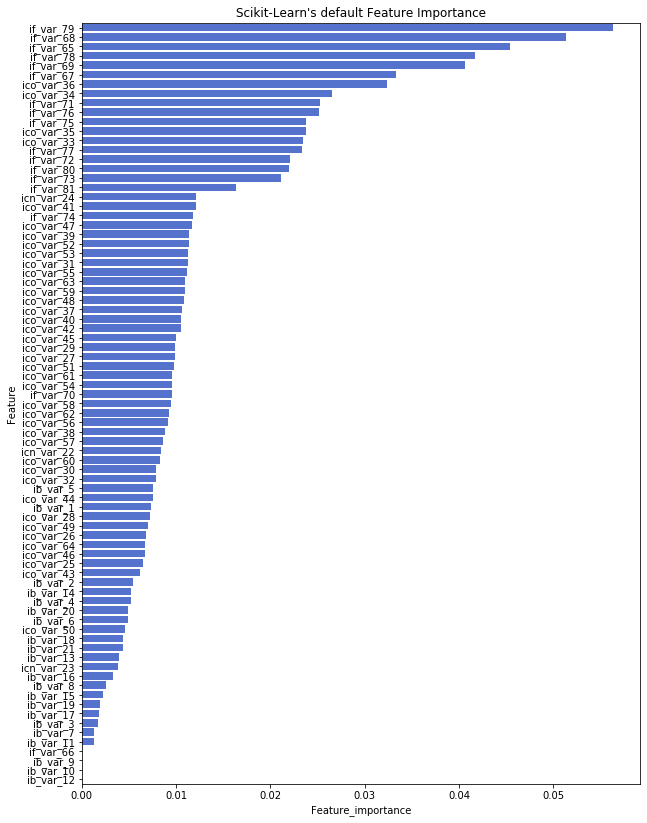

In [9]:
base_imp = imp_df(X.columns, rf.feature_importances_)
var_imp_plot(base_imp, "Scikit-Learn's default Feature Importance")

As can be seen, the variables that seem the most important are the continuous ones as well as the categorical ones. But as highlighted by the above mentionned article, one of the disadvantage of this approach is is is somewhat biased, inflating the importance of continuous features or categorical variables. 
I nonetheless try running a model with the selected features only to try seeing if a higher score can be achieved. I take a treshold of the values higher than a 0.007 of importance and run a model without hyperparameter optimization:

In [37]:
selected_features = base_imp['Feature'][base_imp['Feature_importance']>0.007].to_list()
print("The number of variables selected above the 0.007 treshold are: " + str(len(selected_features)) + " columns.")

The number of variables selected above the 0.007 treshold are: 54 columns.


Running the base Random Forrest I get:

In [25]:
X = df[selected_features]
y = df[output_var]
Xo = dfo[selected_features] 
rf = RandomForestClassifier(random_state=5)
pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.315477730848; GINI = 0.446903390974; GRADE = 7.476'

With fewer variables, the performance seems poorer than when all the variables are included (8.549 grade). I try running the model with the hyperparameter optimized:

In [34]:
only1 = df[df['ob_target']==1]
result = df.append(only1)
#result = result.append(only1)
X = result[selected_features]
y = result[output_var]
Xo = dfo[selected_features] ##x out of time
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample', criterion='gini', max_depth=None,
                                              max_features='auto', max_leaf_nodes=None, max_samples=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,n_estimators=2015, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)
pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.369567879555; GINI = 0.513550263866; GRADE = 8.758'

With the some hyperparameter tunning, the model seems to give a somewhat decent result. With almost half the variables, the scores achieved are acceptable, which I believe shows that a proper approach to feature selection could lead to an increase in the model performance. I thus explore further ways of selecting features.

## 6.2 Feature Importance by permutation
This approach to feature selection measures directly the importance by assessing how random re-shuffling of each predictor in the data will influence the model performance.
It first trains the model and saves the score; it then re-shuffles the values from one variable in the studied dataset, pass the dataset to the model again to get the predictions and compute the gini score for this modified dataset. The feature importance will then be the difference between the benchmark score and the one from the modified  dataset. And this will be repeated for all features.

In [58]:
X = df[in_model]
y = df[output_var]
rf = RandomForestClassifier(random_state=5)

def gini_score(rf, X, y):
    return 2*roc_auc_score(y, rf.predict(X))

perm_imp_rfpimp = permutation_importances(rf, X, y, gini_score)
perm_imp_rfpimp.reset_index(drop = False, inplace = True)

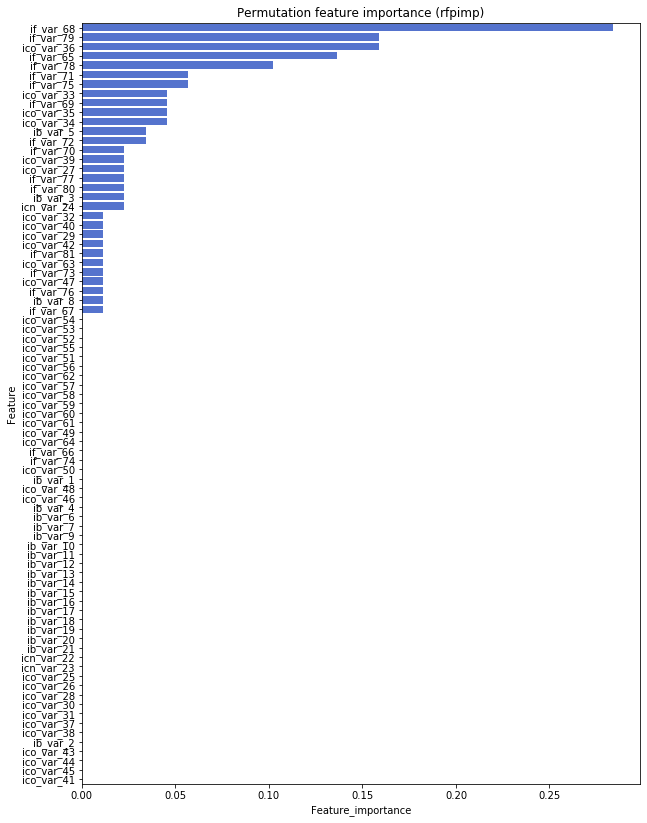

In [59]:
var_imp_plot(perm_imp_rfpimp, 'Permutation feature importance (rfpimp)')

In [60]:
selected_features2 = perm_imp_rfpimp['Feature'][perm_imp_rfpimp['Feature_importance']>0].to_list()
print("The number of variables selected above the 0.00 treshold are: " + str(len(selected_features2)) + " columns.")

The number of variables selected above the 0.00 treshold are: 31 columns.


In [50]:
X = df[selected_features2]
y = df[output_var]
Xo = dfo[selected_features2] 
rf = RandomForestClassifier(random_state=5)
pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.354564275086; GINI = 0.476710736698; GRADE = 8.402'

With only 29 columns selected, the performance is almost the same as the base model, proving once more that many variables are less significant for the model. I rerun the model with some optimized parameters:

In [61]:
X = df[selected_features2]
y = df[output_var]
Xo = dfo[selected_features2] 
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,n_estimators=2015, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)
pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.363775312156; GINI = 0.506221175796; GRADE = 8.62'

There is an increased performance with the tweak in parameters but not that significant, probably a better selection of variables could lead to better results.

## 6.3 Feature Selection based on the PSI
As mentionned in the [Statistics for Machine Learning](https://books.google.com.lb/books?id=C-dDDwAAQBAJ&pg=PA94&lpg=PA94&dq=population+stability+index+(PSI):+this+is+the+metric+used+to+check+that+drift&source=bl&ots=j1br-tuY-q&sig=ACfU3U3lxkf0DwE9WK_8IefldeOjRf3m_Q&hl=fr&sa=X&ved=2ahUKEwictYbC8srpAhV-BGMBHfh2B2gQ6AEwB3oECAoQAQ#v=onepage&q=population%20stability%20index%20(PSI)%3A%20this%20is%20the%20metric%20used%20to%20check%20that%20drift&f=false) book, the Population Stability Index is a metric used to check that the drift/change in the current population on which the model is used will be the same as the population in the deevelopment time. And generally, from the value, we could infer that:
- A PSI lower than 0.1 indicates no change between the two;
- A PSI between 0.1 and 0.25 means that some change has taken place and should call for attention but could still be used in the model;
- A PSI larger than 0.25 means that there is an important shift in the score distribution of the current population as compared to the development time one.

I used the code provided by Professor Manoel Gadi to find this PSI and potentially use it for a model:

In [69]:
def psi(bench, comp, group):
    ben_len=len(bench);
    comp_len=len(comp);
    bench.sort();
    comp.sort();
    psi_cut=[];
    n=int(math.floor(ben_len/group));
    for i in range(1,group):
        lowercut=bench[(i-1)*n+1];
        if i!=group:
            uppercut=bench[(i*n)];
            ben_cnt=n;
        else:
            uppercut=bench[-1];
            ben_cnt=ben_len-group*(n-1)
        comp_cnt = len([i for i in comp if i > lowercut and i<=uppercut]);
        ben_pct=(ben_cnt+0.0)/ben_len;
        comp_pct=(comp_cnt+0.0)/comp_len;
        if comp_pct > 0.0:
            psi_cut.append((ben_pct-comp_pct)*math.log(ben_pct/(comp_pct)));
        else:
            psi_cut.append(0);
    psi=sum(psi_cut);
    return psi;

list_inputs = list()

for var_name in df.columns:
    if re.search('^i',var_name):
        list_inputs.append(var_name)
        
print("The variables abovee the designed treshold of 0.25 are:\n")

for var_name in list_inputs:
    psi_value=psi(bench=list(df[var_name]),comp=list(dfo[var_name]),group=max(2,min((len(df[var_name].unique())),10)));
    if psi_value>0.25:
        print ("psi for ", var_name, " = ", psi_value)

The variables abovee the designed treshold of 0.25 are:

psi for  id  =  0.7945807026518255
psi for  ib_var_17  =  0.257310139829252
psi for  ib_var_19  =  0.28185402261317133
psi for  icn_var_22  =  0.4399049976933703
psi for  ico_var_25  =  0.40433978511173346
psi for  ico_var_26  =  0.7263983488673571
psi for  ico_var_27  =  0.6362428996544015
psi for  ico_var_28  =  0.3673456004522531
psi for  ico_var_29  =  0.3918503438634435
psi for  ico_var_30  =  0.35484735116851723
psi for  ico_var_31  =  0.35918560034609304
psi for  ico_var_32  =  0.42548068581088055
psi for  ico_var_34  =  0.4671779717420689
psi for  ico_var_35  =  0.39920177971399773
psi for  ico_var_36  =  0.3032713332068569
psi for  ico_var_43  =  0.4151434290827771
psi for  ico_var_45  =  0.3504993546567625
psi for  ico_var_46  =  0.637872598014254
psi for  ico_var_49  =  0.33572516504034566
psi for  ico_var_50  =  0.38322342755645294
psi for  ico_var_51  =  0.300032069033377
psi for  ico_var_53  =  0.3151581581534549
ps

I runa model without those variables to see if a significant change takes place or not:

In [70]:
in_model = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_18', 'ib_var_20','ib_var_21', 'icn_var_23', 'icn_var_24', 'ico_var_33', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_44', 'ico_var_47', 'ico_var_48', 
        'ico_var_52', 'ico_var_54','ico_var_56', 'ico_var_58', 'ico_var_62', 'if_var_65', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_74', 'if_var_75','if_var_76', 'if_var_78','if_var_81']

X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] 
rf = RandomForestClassifier(random_state=5)
pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.286507962181; GINI = 0.410995018438; GRADE = 6.789'

Given that our dataset is very special, the consideration of the PSI may not be useful in this case with a significant drop in the scores.

# 7. Dealing with the NAs
Up until now, I had been dealing with the NAs by replacing them by 0. I now consider a different approach using [sklearn's imputers](http://scikit-learn.org/0.18/auto_examples/missing_values.html):

## 7.1 Replacing NAs with the mean

In [144]:
## Development sample
df = pd.read_csv("dev.csv") 
dfo = pd.read_csv("oot0.csv")

X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer = imputer.fit(Xo) 
Xo = imputer.transform(Xo)

rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,n_estimators=2015, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)

pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.349098651559; GINI = 0.496392064622; GRADE = 8.272'

## 7.2 Replacing NAs with the median

In [147]:
## Development sample
df = pd.read_csv("dev.csv") 
dfo = pd.read_csv("oot0.csv")

X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time

imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(Xo) 
Xo = imputer.transform(Xo)


rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,n_estimators=2015, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)

pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.348392776273; GINI = 0.495559108679; GRADE = 8.256'

## 7.3 Replacing NAs using the KNN Imputer
The mean and median ways of imputing the missing values are the traditionnally used ways. I however here try the KNNImputer which uses the n_neighbors nearest neighbors to fill the NAs:

In [153]:
df = pd.read_csv("dev.csv") 
dfo = pd.read_csv("oot0.csv")
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time
imputer = KNNImputer(n_neighbors=2)
imputer = imputer.fit(Xo) 
Xo = imputer.transform(Xo)
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,n_estimators=2000, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)
pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
filename = "student_sub"+str(1)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.349512241333; GINI = 0.496300797604; GRADE = 8.282'

Increasing the number of neighbors:

In [155]:
df = pd.read_csv("dev.csv") 
dfo = pd.read_csv("oot0.csv")
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time
imputer = KNNImputer(n_neighbors=6)
imputer = imputer.fit(Xo) 
Xo = imputer.transform(Xo)
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample', criterion='gini', max_depth=None, max_features='auto', max_leaf_nodes=None, max_samples=None,min_impurity_decrease=0.0,min_impurity_split=None,min_samples_leaf=1,min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,n_estimators=2000, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)
pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
filename = "student_sub"+str(1)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.34913330992; GINI = 0.495959990388; GRADE = 8.273'

Increasing the number of neighbors did not improve the performance of the model thus leaving 2 neighbors as the better parameter here.

## 7.4 Replacing NAs manually with a probability

instead of imputing the NAs with a strategy, we could impute these rows with simply the probability of 0, 1 or other numbers. 

In [43]:
df = pd.read_csv("dev.csv") 
dfo = pd.read_csv("oot0.csv")

def is_NaN_value(value):
    try:
        if np.isnan(float(value)): #If current row is NaN, then return True
            return True
    except:
        True
    return False
col = 'ib_var_1'
row_not_to_predict = np.vectorize(is_NaN_value)(dfo[col])

for col in ['ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50','ico_var_51', 'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55','ico_var_56', 'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60','ico_var_61', 'ico_var_62', 'ico_var_63', 'ico_var_64', 'if_var_65','if_var_66', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']:
    row_not_to_predict = np.vectorize(is_NaN_value)(dfo[col]) | row_not_to_predict

dfo['row_not_to_predict'] = row_not_to_predict #THE ROWS WITH True THE MODEL SHOULD NOT APPLY - YOU SHOULD "MANUALLY" MARK THEN AS 1 or 0!

In [45]:
pd.set_option('display.max_rows', 20)
dfo[dfo['row_not_to_predict']]

,id,ib_var_1,ib_var_2,ib_var_3,ib_var_4,ib_var_5,ib_var_6,ib_var_7,ib_var_8,ib_var_9,ib_var_10,ib_var_11,ib_var_12,ib_var_13,ib_var_14,ib_var_15,ib_var_16,ib_var_17,ib_var_18,ib_var_19,ib_var_20,ib_var_21,icn_var_22,icn_var_23,icn_var_24,ico_var_25,ico_var_26,ico_var_27,ico_var_28,ico_var_29,ico_var_30,ico_var_31,ico_var_32,ico_var_33,ico_var_34,ico_var_35,ico_var_36,ico_var_37,ico_var_38,ico_var_39,ico_var_40,ico_var_41,ico_var_42,ico_var_43,ico_var_44,ico_var_45,ico_var_46,ico_var_47,ico_var_48,ico_var_49,ico_var_50,ico_var_51,ico_var_52,ico_var_53,ico_var_54,ico_var_55,ico_var_56,ico_var_57,ico_var_58,ico_var_59,ico_var_60,ico_var_61,ico_var_62,ico_var_63,ico_var_64,if_var_65,if_var_66,if_var_67,if_var_68,if_var_69,if_var_70,if_var_71,if_var_72,if_var_73,if_var_74,if_var_75,if_var_76,if_var_77,if_var_78,if_var_79,if_var_80,if_var_81,row_not_to_predict
0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1,1.0,4,4.0,4,4,4,3,4,4,NaN,0,0,0,4.0,4,2,3,3,4,4,4,2,4,2,4,2,2,2,4,2,4,4,4,2,3,2,2,2,2,3,2,43,100,8,7196.000000,5140.000000,1,4,5,0.775,1.0,10.0,11.000000,0.666667,NaN,5140.0,0.666667,3,True
2,3,0,0,0,0,1,1,0,0,0,0,0,1,1,0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1,1.0,4,4.0,4,3,4,3,3,4,1.0,11,23,9,3.0,3,4,3,4,4,4,5,2,4,4,4,1,3,2,2,2,4,3,2,2,4,2,1,3,3,2,2,28,100,5,1028.000000,6168.000000,2,6,7,0.725,0.0,8.0,6.000000,0.700000,NaN,2570.0,0.766667,1,True
8,9,0,1,0,0,1,1,0,0,0,0,0,1,0,1,1.0,1.0,1.0,1.0,1.0,1.0,0.0,3.0,5,3.0,4,5.0,5,1,5,2,4,5,7.0,7,19,7,3.0,4,2,1,4,1,5,5,1,5,3,1,2,5,4,1,5,3,1,2,1,3,3,3,3,1,2,1,30,100,5,205.600006,925.200012,1,1,2,0.775,5.0,4.0,3.000000,0.500000,NaN,1028.0,0.666667,0,True
10,11,0,1,0,1,1,1,0,0,0,0,0,1,0,1,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1,2.0,4,3.0,5,5,4,5,4,5,9.0,17,9,9,4.0,2,4,2,4,2,4,2,3,5,2,4,1,2,4,4,2,4,1,2,2,2,2,2,1,4,2,2,39,100,14,616.799988,12027.599610,1,2,3,0.875,4.0,4.0,6.000000,0.600000,NaN,4112.0,0.666667,1,True
11,12,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,2.0,1,2.0,5,5.0,5,5,4,3,5,4,5.0,17,7,5,4.0,2,4,2,4,1,5,4,2,4,2,1,1,1,1,2,2,2,2,2,2,4,2,2,2,1,2,2,44,100,12,411.200012,10280.000000,1,4,4,0.900,0.0,6.0,8.000000,0.566667,NaN,5140.0,0.600000,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2894,2895,1,1,0,0,1,0,0,0,0,0,0,1,0,1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,2.0,1,NaN,3,4.0,4,2,3,3,2,4,5.0,12,12,1,3.0,3,3,4,3,3,4,5,2,5,4,4,3,2,2,3,2,4,3,1,3,3,3,2,3,3,2,2,34,100,4,792.900024,4405.000000,1,3,4,0.625,1.0,8.0,4.000000,0.633333,32.7317,2643.0,0.800000,0,True
2895,2896,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN,1,1.0,4,3.0,3,3,3,3,3,4,1.0,9,23,9,4.0,4,3,3,3,3,4,3,3,4,3,3,3,3,2,3,2,4,2,3,3,4,2,3,3,3,3,3,50,100,7,881.000000,1762.000000,1,2,4,0.650,0.0,11.0,10.000000,0.666667,4.4146,8810.0,0.666667,2,True
2900,2901,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,NaN,1,2.0,3,3.0,4,3,3,3,3,3,1.0,7,12,9,3.0,3,3,2,3,3,3,2,3,3,3,3,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,37,100,14,881.000000,8810.000000,2,6,7,0.625,0.0,13.0,17.000000,0.566667,2.7317,4405.0,0.566667,3,True
2954,2955,0,1,0,1,0,1,0,1,0,0,1,1,0,0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1,NaN,4,4.0,4,4,4,4,4,4,5.0,9,12,1,2.0,2,2,2,2,2,4,4,2,4,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,38,100,10,881.000000,13215.000000,10,1,1,0.800,0.0,19.0,19.000000,0.400000,1.4324,2643.0,0.600000,3,True


I had some difficulties implementing the code in python for doing the replacement manually. So I downloaded the predicted datasets, and changed them directly manually and uploaded them onto the website and the results were as follows:

- Filling the NAs' prediction with 0: decrease of KS2 score by 0.02
- Filling the NAs' prediction with 1: decrease of KS2 score by 0.015
- Filling the NAs' prediction with 0.5: decrease of KS2 score by 0.022

I can thus conclude that filling manually the values do not help in the predictions.

# 8. Some Preprocessing steps 
We can now try various preprocessing ideas to see if they will affect the performance of the model.

## 8.1 Scaling with MinMaxScaler
For fixing the scale of the data, I decided to use the MinMaxScaler from scikit-learn:

In [100]:
df = pd.read_csv("dev.csv")
dfo = pd.read_csv("oot0.csv")
df = df.fillna(0)
dfo = dfo.fillna(0)

num = df[['if_var_65','if_var_66', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75',
       'if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']]

num2 = dfo[['if_var_65','if_var_66', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75',
            'if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']]

nonnum = df[['id', 'ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5','ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35',
       'ico_var_36','ob_target', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50','ico_var_51', 'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55','ico_var_56', 'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60','ico_var_61', 'ico_var_62', 'ico_var_63', 'ico_var_64']]

nonnum2 = dfo[['id', 'ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5','ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35',
       'ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50','ico_var_51', 'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55','ico_var_56', 'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60','ico_var_61', 'ico_var_62', 'ico_var_63', 'ico_var_64']]

In [101]:
#I assign the minmaxscaler from the library:
mm_scaler = preprocessing.MinMaxScaler()

#I apply it to the dataframe:
num_scaled = mm_scaler.fit_transform(num)
num_scaled2 = mm_scaler.fit_transform(num2)

# I take the names from the dataframe containing the numerical variables:
col_names = list(num.columns)
col_names2 = list(num2.columns)

#I reassign the names to the columns
num_scaled = pd.DataFrame(num_scaled, columns=col_names)
num_scaled2 = pd.DataFrame(num_scaled2, columns=col_names2)

#we can see the if the values are scaled:
num_scaled.head()

,if_var_65,if_var_66,if_var_67,if_var_68,if_var_69,if_var_70,if_var_71,if_var_72,if_var_73,if_var_74,if_var_75,if_var_76,if_var_77,if_var_78,if_var_79,if_var_80,if_var_81
0,0.238095,1.0,0.150,0.523810,0.208479,0.000000,0.384615,0.357143,0.619048,0.000000,0.277778,0.263158,0.375000,0.206399,0.335946,0.666667,0.2
1,0.309524,1.0,0.125,0.083333,0.086352,0.000000,0.153846,0.071429,0.857143,0.454545,0.388889,0.263158,0.250000,0.166191,0.167872,0.571429,0.8
2,0.690476,1.0,0.250,0.107143,0.208479,0.000000,0.307692,0.142857,0.619048,0.272727,0.500000,0.315789,0.625000,0.243926,0.335946,0.523810,0.4
3,0.214286,1.0,0.250,0.464286,0.119118,0.071429,0.307692,0.357143,0.666667,0.454545,0.222222,0.315789,0.291667,0.175306,0.067028,0.666667,0.6
4,0.380952,1.0,0.375,0.107143,0.044650,0.000000,0.000000,0.142857,0.619048,0.000000,0.555556,0.263158,0.625000,0.121160,0.335946,0.619048,0.6


In [102]:
num_scaled2.head()

,if_var_65,if_var_66,if_var_67,if_var_68,if_var_69,if_var_70,if_var_71,if_var_72,if_var_73,if_var_74,if_var_75,if_var_76,if_var_77,if_var_78,if_var_79,if_var_80,if_var_81
0,0.396825,1.0,0.200,0.821749,0.148932,0.000000,0.230769,0.2500,0.653846,0.066667,0.526316,0.578947,0.583333,0.000000,0.335946,0.523810,0.6
1,0.206349,1.0,0.150,0.049325,0.148932,0.000000,0.000000,0.3125,0.615385,0.000000,0.421053,0.526316,0.500000,0.283143,0.335946,0.619048,0.0
2,0.158730,1.0,0.125,0.108743,0.178718,0.020408,0.384615,0.3750,0.576923,0.000000,0.421053,0.315789,0.625000,0.000000,0.167872,0.666667,0.2
3,0.142857,1.0,0.125,0.037442,0.074466,0.000000,0.153846,0.1875,0.884615,0.133333,0.368421,0.263158,0.458333,0.340950,0.134257,0.761905,0.0
4,0.253968,1.0,0.150,0.061209,0.148932,0.040816,0.000000,0.2500,0.884615,0.000000,0.526316,0.368421,0.166667,0.391264,0.309054,0.476190,0.4


## 8.2 Fixing Skewness
Looking at the features, many of the numerical continuous ones look skewed, fixing their skewness could maybe lead to improvement of the model. I here use a function implemented from this [github repository](https://github.com/renero/dataset/blob/master/dataset/dataset.py):

In [103]:
def skewed_features(df, threshold=0.75, fix=False, return_series=True):
        feature_skew = df.apply(
            lambda x: skew(x)).sort_values(ascending=False)
        if fix is True:
            high_skew = feature_skew[feature_skew > threshold]
            skew_index = high_skew.index
            for feature in skew_index:
                df[feature] = boxcox1p(
                    df[feature], boxcox_normmax(df[feature] + 1))
            feature_skew = df.apply(
            lambda x: skew(x)).sort_values(ascending=False)
        if return_series is True:
            return feature_skew

In [105]:
# Looking at the skewness of the development data:
skewed_features(num, fix= False)

if_var_70     6.277899
if_var_74     2.955362
if_var_69     1.904821
if_var_68     1.697987
if_var_79     1.666245
if_var_67     1.603695
if_var_78     1.555615
if_var_76     0.992654
if_var_71     0.701300
if_var_75     0.673928
if_var_72     0.570464
if_var_65     0.338627
if_var_80     0.202374
if_var_81     0.016203
if_var_73    -0.190267
if_var_77    -0.219504
if_var_66   -22.469839
dtype: float64

In [106]:
# Looking at the skewness of the oot data:
skewed_features(num2, fix= False)

if_var_70    18.084994
if_var_74     2.917955
if_var_69     1.839562
if_var_68     1.832461
if_var_79     1.826398
if_var_78     1.672071
if_var_67     1.582539
if_var_76     0.876468
if_var_72     0.632438
if_var_75     0.622399
if_var_71     0.583520
if_var_65     0.373355
if_var_80     0.329321
if_var_81     0.029467
if_var_77    -0.141047
if_var_73    -0.180814
if_var_66   -20.473944
dtype: float64

In [107]:
# Fixing the skewness
skewed_features(num, fix= True)
skewed_features(num2, fix= True);

In [118]:
df1 = num.join(nonnum)
dfo1 = num2.join(nonnum2)
X = df1[in_model]
y = df1[output_var]
Xo = dfo1[in_model] ##x out of time
rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample',criterion='gini', max_depth=None,
                                              max_features='auto',max_leaf_nodes=None,max_samples=None,
                                              min_impurity_decrease=0.0,min_impurity_split=None,
                                              min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,
                                              n_estimators=1200, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)

pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.341442619618; GINI = 0.487809499164; GRADE = 8.091'

Surprisingly, the fixing of skewness and scaling did not help improve the model.

## 8.3 Binning the continuous variables

I have tried binning the continuous variables into equal width bins after scaling but this did not improve the model performance, leading to the abandonment of the idea.

## 8.4 Dummy encoding the categorical variables 

I have tried as well dummy encoding the categorical variables with no success as well and thus did not pursue the idea.

# 9. Feature Creation 
I have tried generating some new features with the polynomial features function as seen below:

## 9.1 Polynomial Features 

In [119]:
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model]

# Implementing the PolynomialFeatures
X = PolynomialFeatures(2, interaction_only=False).fit_transform(X)
Xo = PolynomialFeatures(2, interaction_only=False).fit_transform(Xo)

rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample',criterion='gini', max_depth=None,
                                              max_features='auto',max_leaf_nodes=None,max_samples=None,
                                              min_impurity_decrease=0.0,min_impurity_split=None,
                                              min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,
                                              n_estimators=1200, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)

pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.365498987976; GINI = 0.510779905544; GRADE = 8.661'

In [124]:
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model]

# Implementing the PolynomialFeatures
X = PolynomialFeatures(3, interaction_only=False).fit_transform(X)
Xo = PolynomialFeatures(3, interaction_only=False).fit_transform(Xo)

rf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced_subsample',criterion='gini', max_depth=None,
                                              max_features='auto',max_leaf_nodes=None,max_samples=None,
                                              min_impurity_decrease=0.0,min_impurity_split=None,
                                              min_samples_leaf=1,min_samples_split=2,min_weight_fraction_leaf=0.0,
                                              n_estimators=1200, n_jobs=-1,oob_score=False,random_state=5, verbose=0,warm_start=False)

pred_dev = rf.fit(X, y).predict_proba(X)[:,1]
pred_oot  = rf.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.358074011775; GINI = 0.502992171832; GRADE = 8.485'

Polynomial feature generations did not improve the score of the initial model.


# 10. Combining insights for the  Models

From the insights gathered all throughout the flow, I combine them into various models that I test here before choosing the best model:

## 10.1 XGBClassifier 

### 10.1.1 XGBC Model I
The approaches included: ``Manual Hyper parameter tunning``

In [126]:
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time
xgbcla = XGBClassifier(booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=5, seed=None, silent=True)

pred_dev = xgbcla.fit(X, y).predict_proba(X)[:,1]
pred_oot  = xgbcla.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.334043059548; GINI = 0.411678943428; GRADE = 7.916'

### 10.1.2 XGBC Model  II
The approaches included: ``Manual Hyper parameter tunning`` + ``Oversampling`` 

In [128]:
X = df[in_model]
y = df[output_var]
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

X = X_over
y = y_over
Xo = dfo[in_model] ##x out of time
xgbcla = XGBClassifier(booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=5, seed=None, silent=True)

pred_dev = xgbcla.fit(X, y).predict_proba(X)[:,1]
pred_oot  = xgbcla.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.331618129558; GINI = 0.41020249725; GRADE = 7.858'

### 10.1.3 XGBC Model III
The approaches included: ``Manual Hyper parameter tunning`` + ``Manually duplicated Fraud`` + ``Manual Feature Selection``

In [129]:
only1 = df[df['ob_target']==1]
result = df.append(only1)
result = result.append(only1)

features_selected = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5','ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 
            'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']

X = result[features_selected]
y = result[output_var]
Xo = dfo[features_selected] ##x out of time
xgbcla = XGBClassifier(booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=5, seed=None, silent=True)

pred_dev = xgbcla.fit(X, y).predict_proba(X)[:,1]
pred_oot  = xgbcla.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.351805469551; GINI = 0.431732271093; GRADE = 8.337'

## 10.2 CatBoost Classifier 

### 10.2.1 CATB Model I
The approaches included: ``Manual Hyper parameter tunning``

In [134]:
in_model = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50',
       'ico_var_51', 'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55','ico_var_56', 'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60','ico_var_61', 'ico_var_62', 'ico_var_63', 'ico_var_64', 'if_var_65','if_var_66', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model] ##x out of time
catb = CatBoostClassifier(random_seed=5, eval_metric = 'Logloss', n_estimators = 2000)
blockPrint()
pred_dev = catb.fit(X, y).predict_proba(X)[:,1]
pred_oot  = catb.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.356642621466; GINI = 0.465246906164; GRADE = 8.451'

### 10.2.2 CATB Model  II
The approaches included: ``Manual Hyper parameter tunning`` + ``Oversampling``

In [136]:
in_model = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50',
       'ico_var_51', 'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55','ico_var_56', 'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60','ico_var_61', 'ico_var_62', 'ico_var_63', 'ico_var_64', 'if_var_65','if_var_66', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']
X = df[in_model]
y = df[output_var]
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

X = X_over
y = y_over
Xo = dfo[in_model] ##x out of time
catb = CatBoostClassifier(random_seed=5, eval_metric = 'Logloss', n_estimators = 2000)
blockPrint()
pred_dev = catb.fit(X, y).predict_proba(X)[:,1]
pred_oot  = catb.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.377830432814; GINI = 0.463065739979; GRADE = 8.953'

### 10.2.3 CATB Model III
The approaches included: ``Manual Hyper parameter tunning`` + ``Manually duplicated Fraud`` + ``Manual Feature Selection``

In [137]:
only1 = df[df['ob_target']==1]
result = df.append(only1)
result = result.append(only1)

features_selected = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5','ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 
            'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']

X = result[features_selected]
y = result[output_var]
Xo = dfo[features_selected] ##x out of time
catb = CatBoostClassifier(random_seed=5, eval_metric = 'Logloss', n_estimators = 2000)
blockPrint()
pred_dev = catb.fit(X, y).predict_proba(X)[:,1]
pred_oot  = catb.fit(X, y).predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.382429597316; GINI = 0.483287738334; GRADE = 9.062'

## 10.3 RandomForest Classifier

### 10.3.1 RF Model I
The approaches included: ``Manual Hyper parameter tunning``

In [140]:
in_model = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50',
       'ico_var_51', 'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55','ico_var_56', 'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60','ico_var_61', 'ico_var_62', 'ico_var_63', 'ico_var_64', 'if_var_65','if_var_66', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']
X = df[in_model]
y = df[output_var]
Xo = dfo[in_model]
rf = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_features='log2', 
                                              max_leaf_nodes=None, bootstrap=True, oob_score=True,
                                              n_jobs=1, random_state=5,
                                              verbose=0, warm_start=False, 
                                              class_weight='balanced_subsample', n_estimators = 2000)
fitted_model = rf.fit(X, y)
pred_dev = rf.predict_proba(X)[:,1]
pred_oot  = rf.predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.375561465448; GINI = 0.527450577177; GRADE = 8.9'

### 10.3.2 RF Model  II
The approaches included: ``Manual Hyper parameter tunning`` + ``Oversampling``

In [142]:
in_model = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5', 'ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50',
       'ico_var_51', 'ico_var_52', 'ico_var_53', 'ico_var_54', 'ico_var_55','ico_var_56', 'ico_var_57', 'ico_var_58', 'ico_var_59', 'ico_var_60','ico_var_61', 'ico_var_62', 'ico_var_63', 'ico_var_64', 'if_var_65','if_var_66', 'if_var_67', 'if_var_68', 'if_var_69', 'if_var_70','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']
X = df[in_model]
y = df[output_var]
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)
X = X_over
y = y_over
rf = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_features='log2', 
                                              max_leaf_nodes=None, bootstrap=True, oob_score=True,
                                              n_jobs=1, random_state=5,
                                              verbose=0, warm_start=False, 
                                              class_weight='balanced_subsample', n_estimators = 2000)
fitted_model = rf.fit(X, y)
pred_dev = rf.predict_proba(X)[:,1]
pred_oot  = rf.predict_proba(Xo)[:,1]
dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.382174280723; GINI = 0.527942725903; GRADE = 9.056'

### 10.3.3 RF Model III
The approaches included: ``Manual Hyper parameter tunning`` + ``Manually duplicated Fraud`` + ``Manual Feature Selection``

In [150]:
features_selected = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5','ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 
            'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']

only1 = df[df['ob_target']==1]
result = only1.append(df)
result = result.append(only1)

X = result[features_selected]
y = result[output_var]
Xo = dfo[features_selected]



rf = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_features='log2', 
                                              max_leaf_nodes=None, bootstrap=True, oob_score=True,
                                              n_jobs=1, random_state=5,
                                              verbose=0, warm_start=False, 
                                              class_weight='balanced_subsample', n_estimators = 2000)

fitted_model = rf.fit(X, y)
pred_dev = rf.predict_proba(X)[:,1]
pred_oot  = rf.predict_proba(Xo)[:,1]

dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.42199904805; GINI = 0.539219401288; GRADE = 10.0'

## 10.4 Ensemble Models

### 10.4.1 RF and CATB
VotingClassifier model with:  ``Manual Hyper parameter tunning`` + ``Manually duplicated Fraud`` + ``Manual Feature Selection``

In [159]:
features_selected = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5','ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 
            'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']

only1 = df[df['ob_target']==1]
result = only1.append(df)
result = result.append(only1)

X = result[features_selected]
y = result[output_var]
Xo = dfo[features_selected]



rf = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_features='log2', 
                                              max_leaf_nodes=None, bootstrap=True, oob_score=True,
                                              n_jobs=1, random_state=5,
                                              verbose=0, warm_start=False, 
                                              class_weight='balanced_subsample', n_estimators = 2000)

catb = CatBoostClassifier(random_seed=5, eval_metric = 'Logloss', n_estimators = 2000)

# We create a dictionary with our models:
estimators=[('randomF', rf), ('CatBoostClassifier', catb) ]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')

fitted_model = ensemble.fit(X, y)
pred_dev = ensemble.predict_proba(X)[:,1]
pred_oot  = ensemble.predict_proba(Xo)[:,1]

dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.406393543378; GINI = 0.535233689775; GRADE = 9.63'

### 10.4.2 Combination of 3 RF
VotingClassifier model with:  ``Manual Hyper parameter tunning`` + ``Manually duplicated Fraud`` + ``Manual Feature Selection``

In [162]:
features_selected = ['ib_var_1', 'ib_var_2', 'ib_var_3', 'ib_var_4', 'ib_var_5','ib_var_6', 'ib_var_7', 'ib_var_8', 'ib_var_9', 'ib_var_10','ib_var_11', 'ib_var_12', 'ib_var_13', 'ib_var_14', 'ib_var_15','ib_var_16', 'ib_var_17', 'ib_var_18', 'ib_var_19', 'ib_var_20','ib_var_21', 
            'icn_var_22', 'icn_var_23', 'icn_var_24', 'ico_var_25','ico_var_26', 'ico_var_27', 'ico_var_28', 'ico_var_29', 'ico_var_30','ico_var_31', 'ico_var_32', 'ico_var_33', 'ico_var_34', 'ico_var_35','ico_var_36', 'ico_var_37', 'ico_var_38', 'ico_var_39', 'ico_var_40','ico_var_41', 'ico_var_42', 'ico_var_43', 'ico_var_44', 'ico_var_45','ico_var_46', 'ico_var_47', 'ico_var_48', 'ico_var_49', 'ico_var_50','if_var_71', 'if_var_72', 'if_var_73', 'if_var_74', 'if_var_75','if_var_76', 'if_var_77', 'if_var_78', 'if_var_79', 'if_var_80','if_var_81']

only1 = df[df['ob_target']==1]
result = only1.append(df)
result = result.append(only1)

X = result[features_selected]
y = result[output_var]
Xo = dfo[features_selected]



rf = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_features='log2', 
                                              max_leaf_nodes=None, bootstrap=True, oob_score=True,
                                              n_jobs=1, random_state=5,
                                              verbose=0, warm_start=False, 
                                              class_weight='balanced_subsample', n_estimators = 2000)

rf2 = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_features='log2', 
                                              max_leaf_nodes=None, bootstrap=True, oob_score=True,
                                              n_jobs=1, random_state=5,
                                              verbose=0, warm_start=False, 
                                              class_weight='balanced_subsample', n_estimators = 2910)

rf3 = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2,min_samples_leaf=1, 
                                              min_weight_fraction_leaf=0.0, max_features='log2', 
                                              max_leaf_nodes=None, bootstrap=True, oob_score=True,
                                              n_jobs=1, random_state=5,
                                              verbose=0, warm_start=False, 
                                              class_weight='balanced_subsample', n_estimators = 2955)

# We create a dictionary with our models:
estimators=[('RandomF', rf), ('RandomF2', rf2),('RandomF3', rf3)  ]
#create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting='soft')

fitted_model = ensemble.fit(X, y)
pred_dev = ensemble.predict_proba(X)[:,1]
pred_oot  = ensemble.predict_proba(Xo)[:,1]

dfo['pred'] = pred_oot
dfo_tosend = dfo[list(['id','pred'])]
i=1
filename = "student_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')
files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('mohamed.khanafer', 'mfalonso123'))
resp_str = str(rsub.text)
resp_str

'KS2 = 0.421189197682; GINI = 0.538129973475; GRADE = 9.981'

# 11. Conclusion on the final model chosen
As seen from the above section, the various approaches yielded different results and all can be summarized in the following table:

In [186]:
results = pd.DataFrame({'HP KS2':["0.3340","-","-","0.3566","-","-","0.3755","-","-","-","-"],
                        'HP Grade':["7.916","-","-","8.451","-","-","8.9","-","-","-","-"],
                        'HP + OV KS2': ["-","0.3316","-","-","0.3778","-","-","0.3821","-","-","-"],
                        'HP + OV Grade': ["-","7.858","-","-","8.953","-","-","9.056","-","-","-"],
                        'HP + DUP + FS KS2': ["-","-","0.3518","-","-","0.3824","-","-","0.4219","0.5352","0.5381"],
                        'HP + DUP + FS Grade': ["-","-","8.337","-","-","9.062","-","-","10.0","9.63","9.981"]
                       }, index=["XGBC Model 1", "XGBC Model 2", "XGBC Model 3", "CATB Model 1", "CATB Model 2", "CATB Model 3","RF Model 1","RF Model 2", "RF Model 3","Ensemble: RF and CATB","Ensemble: 3 RF"])

results

,HP KS2,HP Grade,HP + OV KS2,HP + OV Grade,HP + DUP + FS KS2,HP + DUP + FS Grade
XGBC Model 1,0.3340,7.916,-,-,-,-
XGBC Model 2,-,-,0.3316,7.858,-,-
XGBC Model 3,-,-,-,-,0.3518,8.337
CATB Model 1,0.3566,8.451,-,-,-,-
CATB Model 2,-,-,0.3778,8.953,-,-
CATB Model 3,-,-,-,-,0.3824,9.062
RF Model 1,0.3755,8.9,-,-,-,-
RF Model 2,-,-,0.3821,9.056,-,-
RF Model 3,-,-,-,-,0.4219,10.0
Ensemble: RF and CATB,-,-,-,-,0.5352,9.63


### Concluding Remark:
As can be seen in the above table, the best model I got was a Random Forrest following the 3rd approach which is the Hyperparameter Optimization + Duplicated fraud + Feature Selection. 
And I would like to comment on an interesting aspect of this problem. All of these steps were performed manually. Indeed, as mentioned above, the hyper parameters that gave me the best results were those that I manually set. For the resampling approach, the manually duplicated features gave me the best results as well. And finally, for the feature selection, I manually selected the features based on the insights I got running the feature importance functions as well as noticing the high skewness in the float variables. Indeed, it is by excluding those from the model that I got the best results for my model. Given that the variables are not known and that this dataset is somehow a special one, the process I followed including a lot of manual decisions  is for sure not the most appropriate one when it comes to Machine Learning per se but I believe that it shows how for this problem, combining the insights generated from proper machine learning and with some creativity a data scientist can achieve great things. 